#Mount Google Drive

In [1]:
import sys
import os

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
import os
os.chdir('/content/gdrive/My Drive/iss/babydetect/')

Mounted at /content/gdrive


## Environment setup

In [2]:
!pip install tensorflow.io
!pip install ffmpeg moviepy
!pip install librosa
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio

     |████████████████████████████████| 24.1MB 126kB/s 
     |████████████████████████████████| 454.3MB 41kB/s 
     |████████████████████████████████| 2.5MB 41.3MB/s 
     |████████████████████████████████| 4.0MB 19.0MB/s 
     |████████████████████████████████| 471kB 42.0MB/s 
     |████████████████████████████████| 4.0MB 39.8MB/s 
     |████████████████████████████████| 6.0MB 39.0MB/s 
     |████████████████████████████████| 1.2MB 43.8MB/s 
     |████████████████████████████████| 4.9MB 37.9MB/s 
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalle

# Sound classification with YAMNet

YAMNet is a deep net that predicts 521 audio event [classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) from the [AudioSet-YouTube corpus](http://g.co/audioset) it was trained on. It employs the
[Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) depthwise-separable
convolution architecture.

In [3]:
import librosa
import soundfile as sf

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython import display

import moviepy.editor as mp

from scipy.io import wavfile
from scipy.signal import resample

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3104768/45929032 bytes (6.8%)7077888/45929032 bytes (15.4%)11116544/45929032 bytes (24.2%)15040512/45929032 bytes (32.7%)19054592/45929032 bytes (41.5%)22921216/45929032 bytes (49.9%)26869760/45929032 bytes (58.5%)30957568/45929032 bytes (67.4%)34963456/45929032 bytes (76.1%)38821888/45929032 bytes (84.5%)42713088/45929032 bytes (93.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

Load the Model from TensorFlow Hub.

Note: to read the documentation just follow the model's [url](https://tfhub.dev/google/yamnet/1)

In [4]:
# Load the model.
yamnet_model = hub.load('YAMNet')

The labels file will be loaded from the models assets and is present at `model.class_map_path()`.
You will load it on the `class_names` variable.

In [5]:
# solution: loading label names
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:5]:
  print(name)

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling


Add a method to convert a loaded audio is on the proper sample_rate (16K), otherwise it would affect the model's results.

Returned wav_data has been normalized to values in [-1.0, 1.0] (as stated in the model's documentation).

In [6]:
@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents,
                                          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Preparing the sound file

The audio file should be a mono wav file at 16kHz sample rate.

In [7]:
wav_file_name = './datasets/ESC-50-master/audio/1-187207-A-20.wav'

wav_data = load_wav_16k_mono(wav_file_name)

# Play the audio file.
display.Audio(wav_data, rate=16000)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


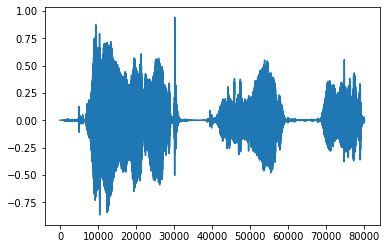

In [8]:
plt.plot(wav_data)

## Executing the Model

Now the easy part: using the data already prepared, you just call the model and get the: scores, embedding and the spectrogram.

The score is the main result you will use.
The spectrogram you will use to do some visualizations later.

In [9]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(wav_data)

In [10]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Speech


In [11]:
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Speech
The embeddings shape: (10, 1024)


## Visualization

YAMNet also returns some additional information that we can use for visualization.
Let's take a look on the Waveform, spectrogram and the top classes inferred.

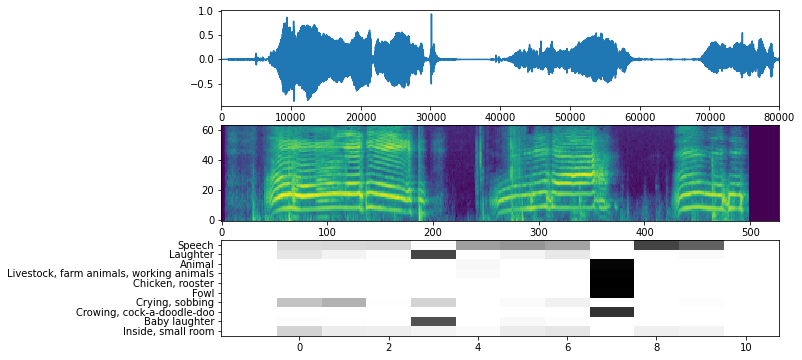

In [12]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(wav_data)
plt.xlim([0, len(wav_data)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

## ESC-50 dataset

The ESC-50 dataset, well described here, is a labeled collection of 2000 environmental audio recordings (each 5 seconds long). The data consists of 50 classes, with 40 examples per class

In [ ]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

## Explore the data

In [13]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Filter the data

In [14]:
my_classes = ['crying_baby', 'laughing']
saved_model_path = './baby_crying_yamnet1'

In [15]:
filtered_pd_crying = pd_data[pd_data.category.isin(['crying_baby'])]
print(len(filtered_pd_crying))

40


In [16]:
map_class_to_id = {'crying_baby':0, 'laughing':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
68,./datasets/ESC-50-master/audio/1-1791-A-26.wav,1,1,laughing,False,1791,A
78,./datasets/ESC-50-master/audio/1-187207-A-20.wav,1,0,crying_baby,True,187207,A
104,./datasets/ESC-50-master/audio/1-211527-A-20.wav,1,0,crying_baby,True,211527,A
105,./datasets/ESC-50-master/audio/1-211527-B-20.wav,1,0,crying_baby,True,211527,B
106,./datasets/ESC-50-master/audio/1-211527-C-20.wav,1,0,crying_baby,True,211527,C
113,./datasets/ESC-50-master/audio/1-22694-A-20.wav,1,0,crying_baby,True,22694,A
114,./datasets/ESC-50-master/audio/1-22694-B-20.wav,1,0,crying_baby,True,22694,B
154,./datasets/ESC-50-master/audio/1-30039-A-26.wav,1,1,laughing,False,30039,A
155,./datasets/ESC-50-master/audio/1-30043-A-26.wav,1,1,laughing,False,30043,A
174,./datasets/ESC-50-master/audio/1-33658-A-26.wav,1,1,laughing,False,33658,A


## Load the audio files and retrieve embeddings

In [17]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [18]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

#main_ds = main_ds.map(lambda a,b,c: tf.py_function(load_wav_for_map, [a, b, c], [tf.float32,tf.int64,tf.int64]))
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [19]:
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]

  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [20]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_ds)

## Create new model

In [21]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), 
                          dtype=tf.float32,
                          name='input_embedding'),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='new_model')

new_model.summary()

Model: "new_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [22]:
new_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [23]:
history = new_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 [==============================] - 19s 31ms/step - loss: 0.7346 - accuracy: 0.8417 - val_loss: 1.7068 - val_accuracy: 0.8687
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 0.4298 - accuracy: 0.9563 - val_loss: 1.3047 - val_accuracy: 0.8750
Epoch 3/20
15/15 [==============================] - 0s 23ms/step - loss: 0.2271 - accuracy: 0.9500 - val_loss: 0.5976 - val_accuracy: 0.8750
Epoch 4/20
15/15 [==============================] - 0s 20ms/step - loss: 0.1243 - accuracy: 0.9729 - val_loss: 0.6132 - val_accuracy: 0.8750
Epoch 5/20
15/15 [==============================] - 0s 24ms/step - loss: 0.1043 - accuracy: 0.9667 - val_loss: 0.7244 - val_accuracy: 0.8750
Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 0.0833 - accuracy: 0.9792 - val_loss: 0.5592 - val_accuracy: 0.8750
Epoch 7/20
15/15 [==============================] - 0s 23ms/step - loss: 0.1088 - accuracy: 0.9854 - val_loss: 0.6870 - val_accuracy: 0.8750
Epoch 8/20
1

Lets run the evaluate method on the test data just to be sure there's no overfitting.

In [24]:
loss, accuracy = new_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 6ms/step - loss: 0.8197 - accuracy: 0.8562
Loss:  0.8197406530380249
Accuracy:  0.856249988079071


## Test your model

In [25]:
test_laughing_data = load_wav_16k_mono('./datasets/ESC-50-master/audio/4-155670-A-26.wav')

scores, embeddings, spectrogram = yamnet_model(test_laughing_data)
result = new_model(embeddings).numpy()
print(result)

infered_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

[[-4.6032257  4.9511847]
 [-5.738488   6.4430575]
 [-4.453185   5.1723323]
 [-2.4040139  2.6843958]
 [-4.567597   4.9364533]
 [-4.525986   4.928245 ]
 [-3.0781057  3.2321312]
 [-3.677969   4.0742025]
 [-3.1771812  3.6150439]
 [-3.8538187  4.499787 ]]
The main sound is: laughing


## Save a model that can directly take a wav file as input

In [26]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [27]:
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer('YAMNet',
                                            trainable=False, 
                                            name='yamnet')

_, embeddings_output, _ = embedding_extraction_layer(input_segment)

serving_outputs = new_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)

serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./baby_crying_yamnet1/assets


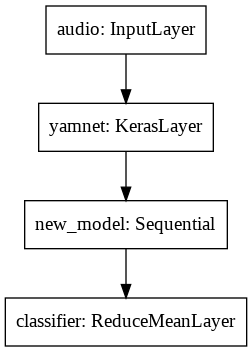

In [28]:
tf.keras.utils.plot_model(serving_model)

## Test new model

## Loading video

In [ ]:
#my_clip = mp.VideoFileClip(r"./datasets/Babies_Crying.mp4")
#my_clip.audio.write_audiofile(r"./datasets/Babies_Crying.wav")


my_clip = mp.VideoFileClip(r"./datasets/climbing.mp4")
my_clip.audio.write_audiofile(r"./datasets/climbing.wav")

In [29]:
#test_laughing_data = load_wav_16k_mono('./datasets/ESC-50-master/audio/4-155670-A-26.wav')
#test_crying_data = load_wav_16k_mono('./datasets/ESC-50-master/audio/4-167077-A-20.wav')
#test_data = load_wav_16k_mono('./datasets/Babies_Crying.wav')
test_data = load_wav_16k_mono('./datasets/climbing.wav')

In [30]:
# loading new model
reloaded_model = tf.saved_model.load(saved_model_path)

In [31]:
# test in new data file
reloaded_results = reloaded_model(test_data)
print(reloaded_results)

baby_sound = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {baby_sound}')

tf.Tensor([-0.7643579  0.6503447], shape=(2,), dtype=float32)
The main sound is: laughing


## Read audio file

In [32]:
sample_rate = 16000
rate = 44100

duration = len(test_data)/sample_rate

print(f'Total duration: {duration:.2f}s')

for i in range(0, int(duration), 5):
  start = i*sample_rate
  end   = (i+5)*sample_rate
  print('duration from {:d} -- {:d}'.format(i, i+5))

  wav_data = test_data[start:end]

  reloaded_results = reloaded_model(wav_data)
  baby_sound = my_classes[tf.argmax(reloaded_results)]
  print(f'The main sound is: {baby_sound}, score: {reloaded_results}, max: {tf.argmax(reloaded_results)}')

  filename = 'clip-{:d}.wav'.format(i)

  data = np.random.uniform(-1, 1, size=(rate * 10, 2))
  sf.write(filename, wav_data, sample_rate, subtype='PCM_24')


Total duration: 36.15s
duration from 0 -- 5
The main sound is: laughing, score: [-1.1112189  1.1639351], max: 1
duration from 5 -- 10
The main sound is: laughing, score: [-1.4409044  1.5036037], max: 1
duration from 10 -- 15
The main sound is: laughing, score: [-0.5819746  0.5331695], max: 1
duration from 15 -- 20
The main sound is: laughing, score: [-0.9682398  0.9436534], max: 1
duration from 20 -- 25
The main sound is: crying_baby, score: [-0.04232998 -0.14082558], max: 0
duration from 25 -- 30
The main sound is: laughing, score: [-1.0432942  0.8221777], max: 1
duration from 30 -- 35
The main sound is: laughing, score: [-1.3736175  1.3177514], max: 1
duration from 35 -- 40
The main sound is: crying_baby, score: [ 1.2458657 -1.5081506], max: 0


## Real-Time audio

In [ ]:
import pyaudio

p = pyaudio.PyAudio()

print(p.get_device_count())

FORMAT          = pyaudio.paInt16
CHANNELS        = 1
RATE            = 44100
RECORD_SECONDS  = 5
CHUNK           = int(RATE/20)

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input = True,
                frames_per_buffer=CHUNK)

while True:
    frames = []
    for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK, exception_on_overflow=False)
        frames.append(np.fromstring(data, dtype=np.float32))
    npdata = np.hstack(frames)

    wav_data = AudioClip.from_np(npdata, RATE)

    #check using model
    reloaded_results = reloaded_model(wav_data)
    baby_sound = my_classes[tf.argmax(reloaded_results)]
    print(f'The main sound is: {baby_sound}')